# Model validation using deep generation of stress data: Part 2

## Background: generative models

| Discriminative models | Generative models |
|:---|:---|
|<img src='https://raw.githubusercontent.com/airi-industrial-ai/ec23-tutorial/main/notebooks/discriminative_learning.png' width=300>|<img src='https://raw.githubusercontent.com/airi-industrial-ai/ec23-tutorial/main/notebooks/generative_learning.png' width=300>|
| Aims to predict the label by the given example| Aims to learn the full data distribution by the given subsample |
| Learns the probability $y \sim P(y|X)$ | Learns the probability $X,y \sim P(X, y)$ or $X \sim P(X)$ |
| _Examples of tasks:_ | _Examples of tasks:_ |
| 1. Is a cat on the photo? | 1. Create a photo of a cat that looks like the average of two given cat photos |
| 2. How old is a person on the photo? | 2. Create a photo of an avocado armchair |
| 3. What is the most likely number of tourists the next mounth? | 3. Write an essay on the topic of global warming |
| _Examples of models:_ | _Examples of models:_ |
| Decision Tree, Support Vector Machine (SVM), Convolutional Neural Network (CNN) | Autoregressive model (AR), Generative Adversarial Network (GAN), Variational Autoencoder (VAE), Generative Pretrained Transformer (GPT)|

_An image is taken from https://medium.com/@jordi299/about-generative-and-discriminative-models-d8958b67ad32_

Deep generative models are based on deep neural networks.

<img src='https://raw.githubusercontent.com/airi-industrial-ai/ec23-tutorial/main/notebooks/space_generator.png' width=600>

## Background: Generative Adversarial Network for time series

<img src='https://raw.githubusercontent.com/airi-industrial-ai/ec23-tutorial/main/notebooks/gan_for_ts.png' width=600>

A Generative Adversarial Network (GAN) is a type of model that consists of two neural networks: a generator and a discriminator.

* The objective of a generator (G) is to create realistic data
* The objective of a discriminator (D) is to detect fake data

We note the multivariate time series as $X_1, X_2, \dots, X_N$, where $X_t \in R^d$

The general objective of GAN is

$$\min_G \max_D V(D, G) = \mathbb E_{X} \log(D(X)) + \mathbb E_{Z} \log(1 - D(G(Z))$$

In this tutorial we use GAN where a generator and a discriminator are Temporal Convolutional Networks (TCN).

<img src='https://raw.githubusercontent.com/airi-industrial-ai/ec23-tutorial/main/notebooks/tcn.png' width=600>

_An image is taken from Oord, Aaron van den, et al. "Wavenet: A generative model for raw audio." arXiv preprint arXiv:1609.03499 (2016)._

The main advantages of TCN:
* Exponentially large receptive field — TCN can detect long and short patterns
* Can be applied to time series of arbitrary length
* Causal convolution prevents leakage from the future

The key parameter of TCN is the number of channels (also known as filters, kernels).

For generator:
* Input channels: latent space dimensionality
* Hidden channels: some large number to model temporal relationships
* Output channels: time series dimensionality

For discriminator:
* Input channels: time series dimensionality
* Hidden channels: some large number to model temporal relationships
* Output channels: 1 (the probability that the data is fake)

## Generation of time series

In [1]:
!pip install git+https://github.com/airi-industrial-ai/ec23-tutorial -q

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.4/722.4 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 13.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from pytorch_lightning import Trainer
import requests

from ectutorial.data import SlidingWindowDataset, get_ett_dataset
from ectutorial.gen_models import TCNGANModule
from ectutorial.plot import plot_pair_fake_val, plot_risk
from ectutorial.wcr import calculate_worst_case_risk

We download the dataset of energy consumption that we used in the first part of the tutorial.

In [3]:
ett = get_ett_dataset()
ett.head()

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
date,,,,,,,
2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000


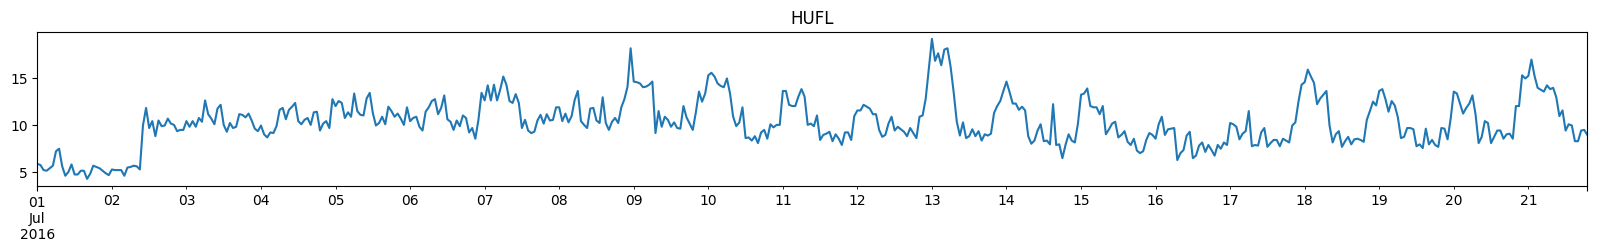

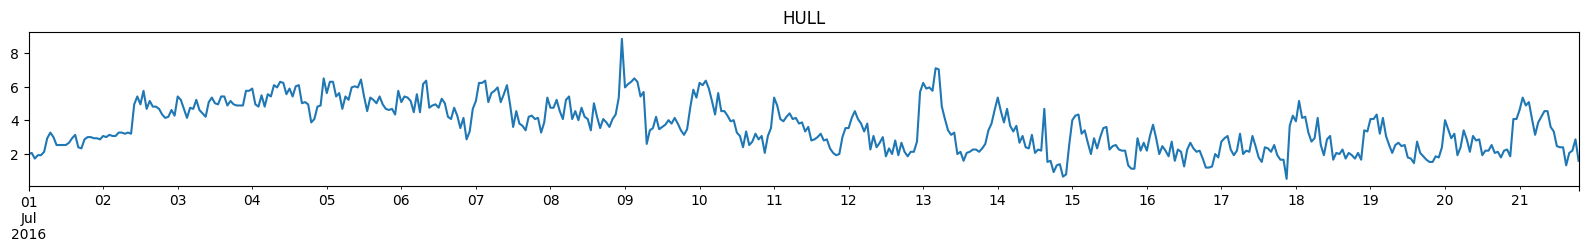

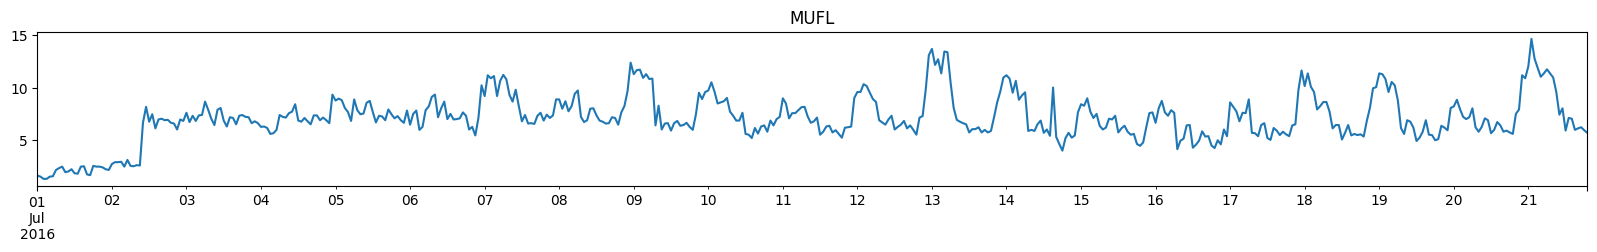

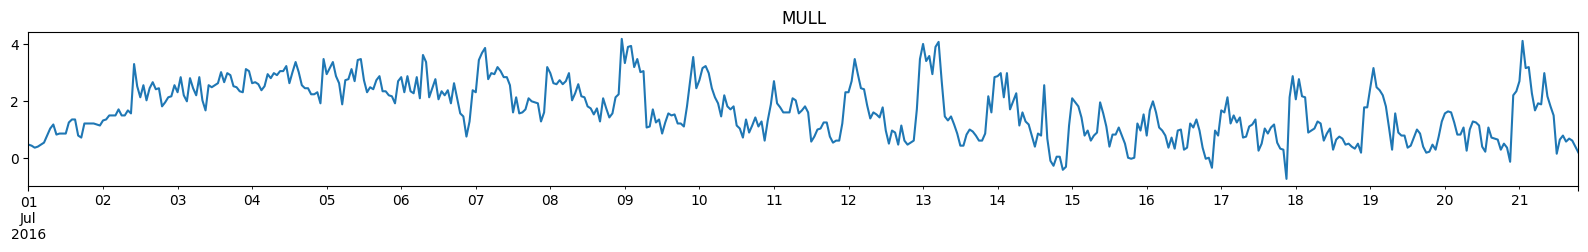

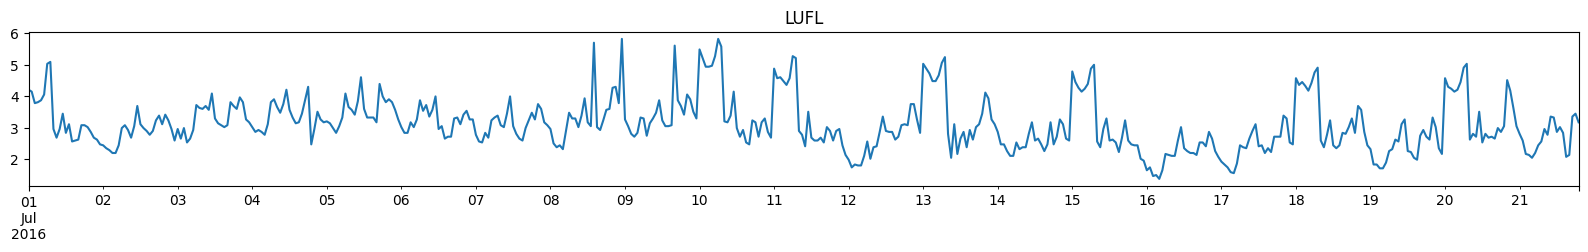

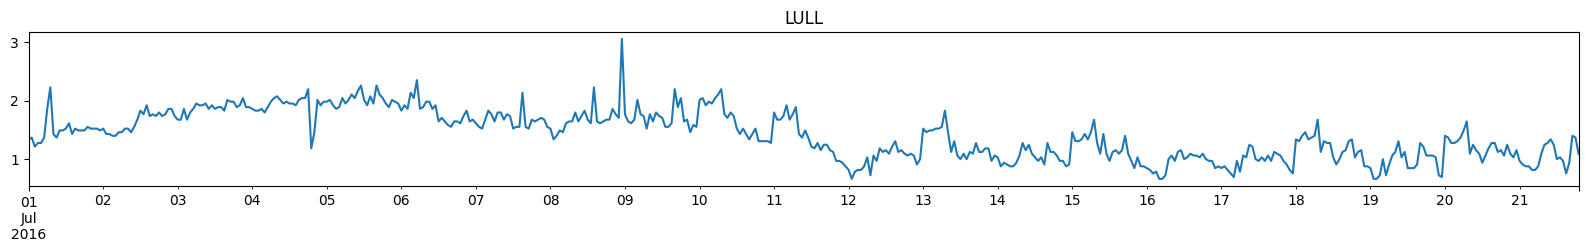

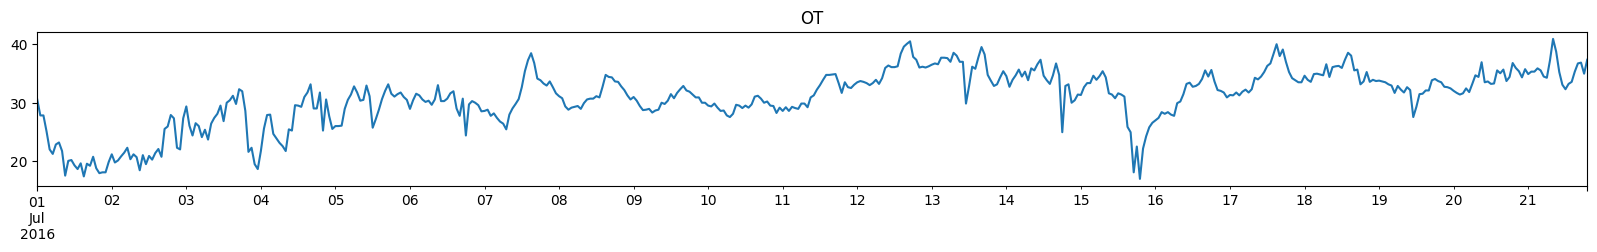

In [4]:
for col in ett.columns:
    plt.figure(figsize=(20, 2))
    ett[col].iloc[:500].plot()
    plt.title(col)
    plt.xlabel('')
    plt.show()

We split the dataset into train, validation, test sets.

<img src='https://raw.githubusercontent.com/airi-industrial-ai/ec23-tutorial/main/notebooks/train_val_test_split.png' width=800>

In [5]:
val_thresh = int(ett.shape[0] * 0.7)
test_thresh = int(ett.shape[0] * 0.85)

train_data = ett.iloc[:val_thresh].copy()
val_data = ett.iloc[val_thresh:test_thresh].copy()
test_data = ett.iloc[test_thresh:].copy()

We apply a standard scaler for training stability.

In [6]:
scaler = StandardScaler()
val_data_norm = scaler.fit_transform(val_data)

We define a sliding window dataset and data loader.

<img src='https://raw.githubusercontent.com/airi-industrial-ai/ec23-tutorial/main/notebooks/sliding_window.png' width=800>

The dataloader split the dataset into batches, where each batch consists of a few time series samples.

We will use the __validation set for training GAN__, since we are looking for shifts with respect to the validation period.

In [7]:
window_size = 200
train_dataset = SlidingWindowDataset(val_data_norm, window_size=window_size, step_size=1)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
len(train_loader)

37

The shape of a batch is (the batch size, the length of time series, the dimensionality of time series).

In [8]:
for batch in train_loader:
    break
batch.shape

torch.Size([64, 200, 7])

Let us define our TCN GAN:
* `latent_dim` — the dimensionality of latent space which is Miltivariate Normal Distribution.
* `hidden_dim` — the number of channels/filters/kernels in the hidden layers
* `target_dim` — the dimenstionality of time series
* `num_layers` — the number of TCN layers
* `lr` — the learning rate for the optimization step

The values of parameters can be tuned using some search strategies, such as grid or random search.

In [9]:
gan = TCNGANModule(
    latent_dim=8,
    target_dim=len(ett.columns),
    hidden_dim=64,
    num_layers=4,
    lr=0.0001,
)

GAN is known as an unstable model in training, since the generator and discriminator fluctuate without a guarantee of convergence. Thus, it is strongly recommended to monitor auxiliary metrics to determine the total number of training steps.

In the case of generating time series, metrics can be:
1. The average discrepancy between a minimum of real and fake time series
2. The average discrepancy between a maximum of real and fake time series
3. The average discrepancy between a mean of real and fake time series

<img src='https://raw.githubusercontent.com/airi-industrial-ai/ec23-tutorial/main/notebooks/gan_training.png' width=600>

In our tutorial, we skip the training part to save time. It takes about 10 minutes on NVIDIA V100 GPU.

In [10]:
"""
trainer = Trainer(
    accelerator='auto',
    max_epochs=200,
    log_every_n_steps=10,
)

trainer.fit(
    model=gan,
    train_dataloaders=train_loader,
    val_dataloaders=train_loader,
)
""";

We load the pretrained model from a `checkpoint` file.

In [11]:
url = 'https://raw.githubusercontent.com/airi-industrial-ai/ec23-tutorial/main/models/ver=6-epoch=0-step=76.ckpt'
r = requests.get(url)
open('ver=6-epoch=0-step=76.ckpt', 'wb').write(r.content);

In [12]:
gan = TCNGANModule.load_from_checkpoint(
    'ver=6-epoch=0-step=76.ckpt',
    map_location='cpu',
    latent_dim=8,
    target_dim=len(ett.columns),
    hidden_dim=64,
    num_layers=4,
    lr=0.0001,
)

Let us plot the pair plot to compare the fake and validation data. We can make fake data more "risky" by increasing the variance of the latent space using the temp parameter.

As our generator is a convolutional network, we can create a sequnce of an arbitrary length, for example 1000.

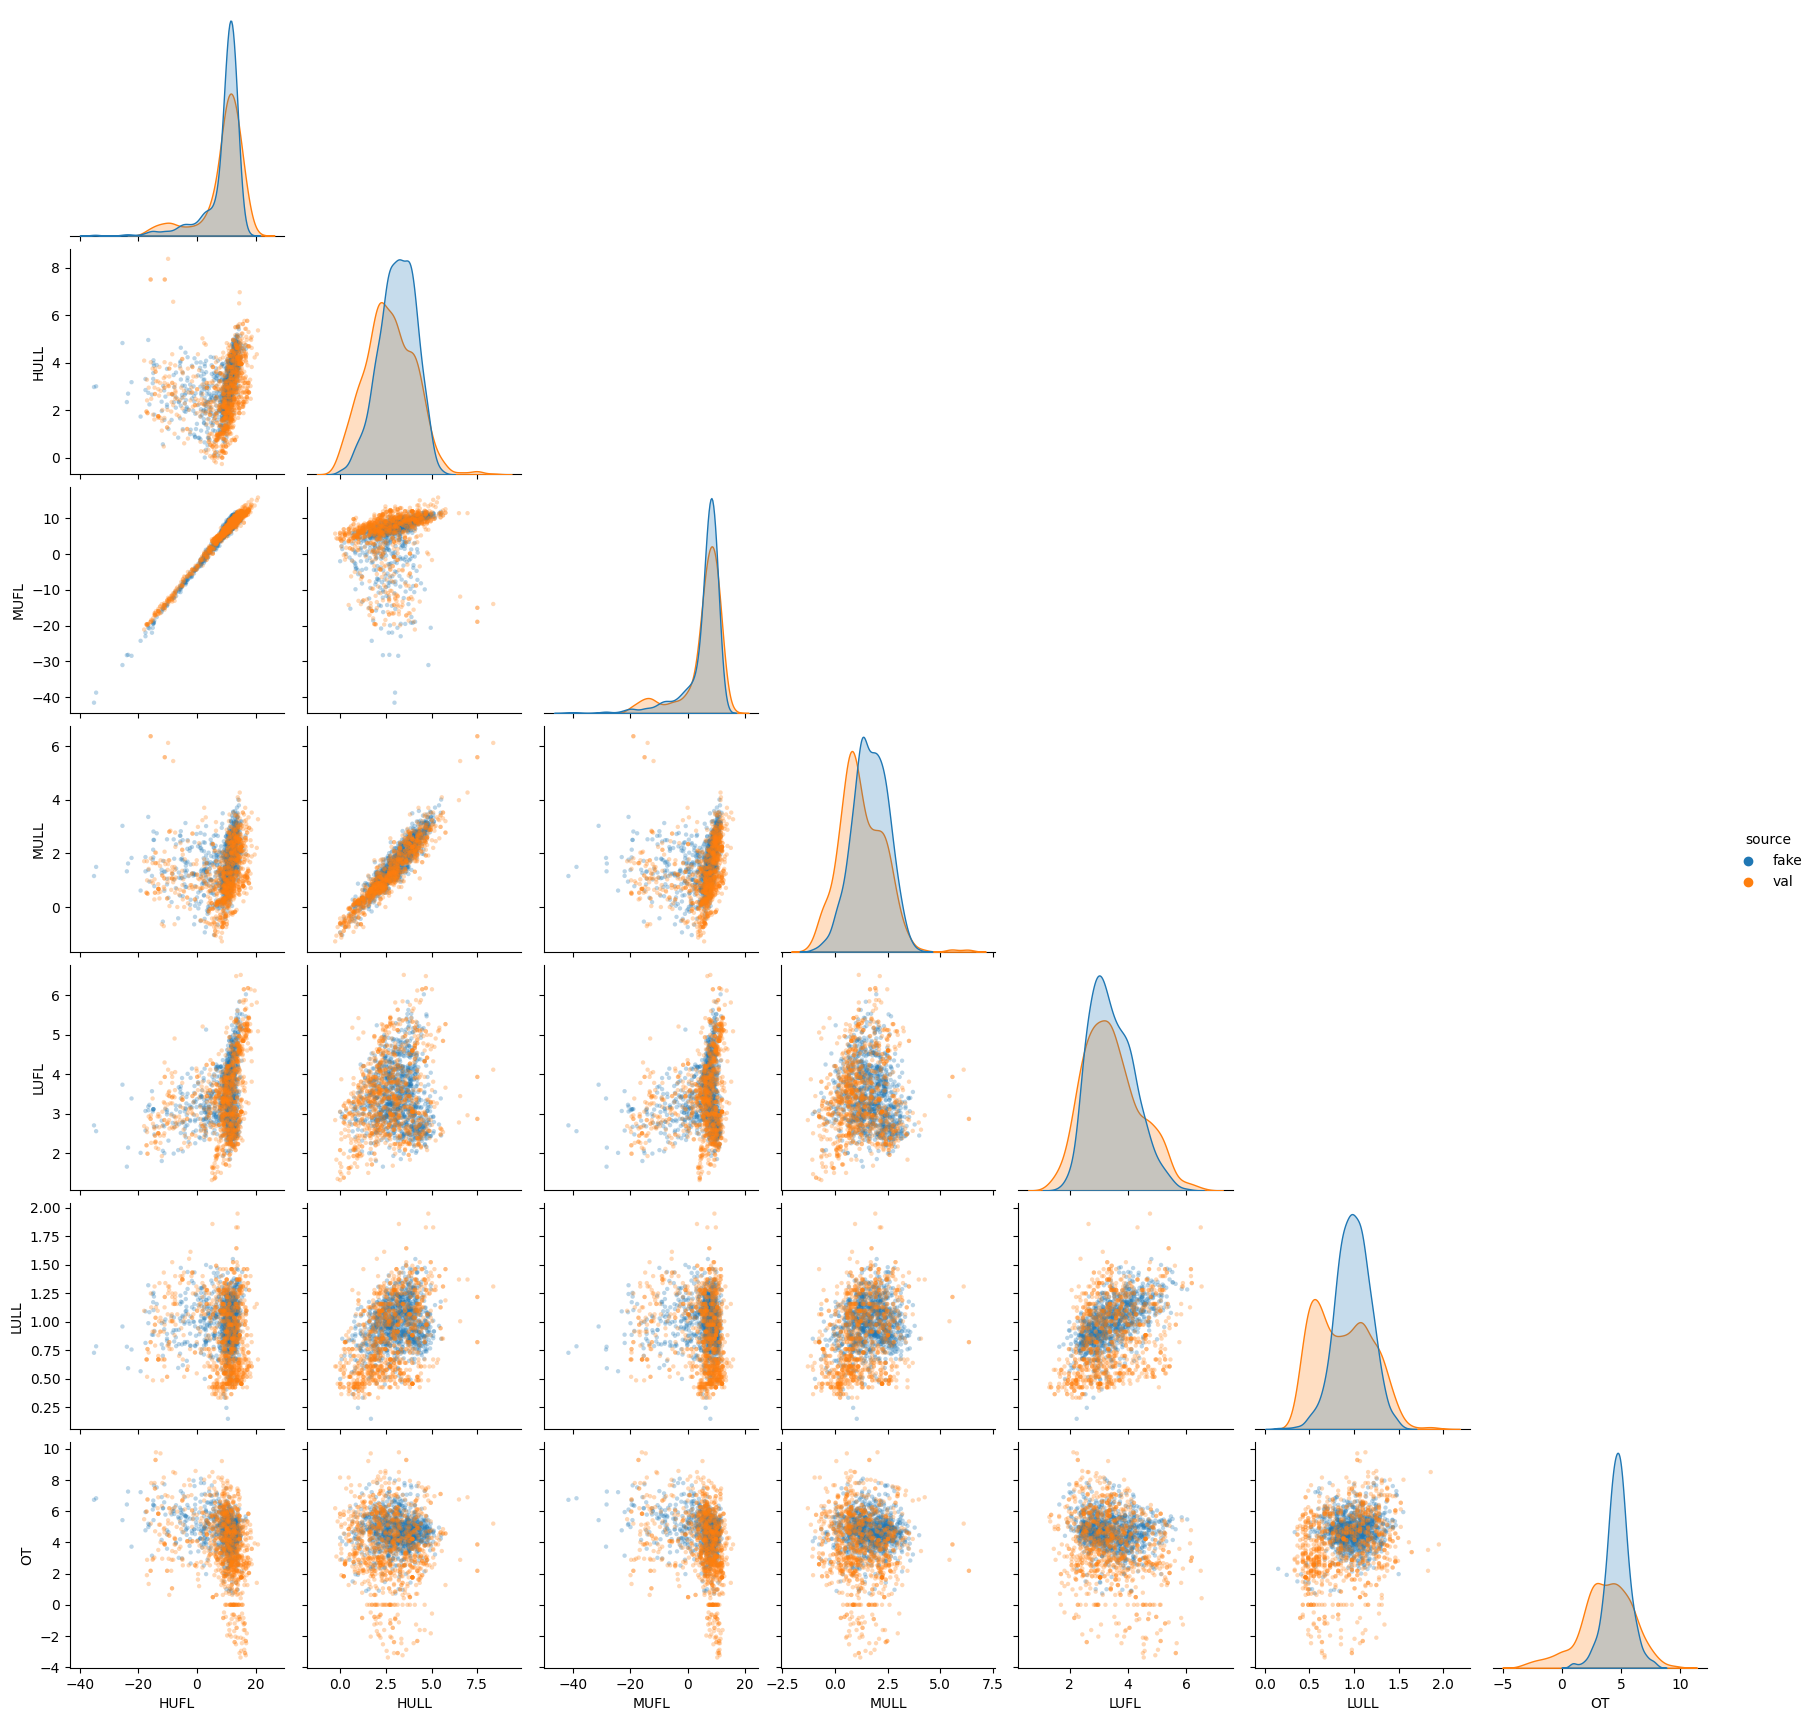

In [13]:
seq_len = 1000
torch.manual_seed(0)
fake = gan.sample(seq_len, temp=1)

plot_pair_fake_val(fake, val_data, scaler)

Let's also plot the trajectories of fake time series.

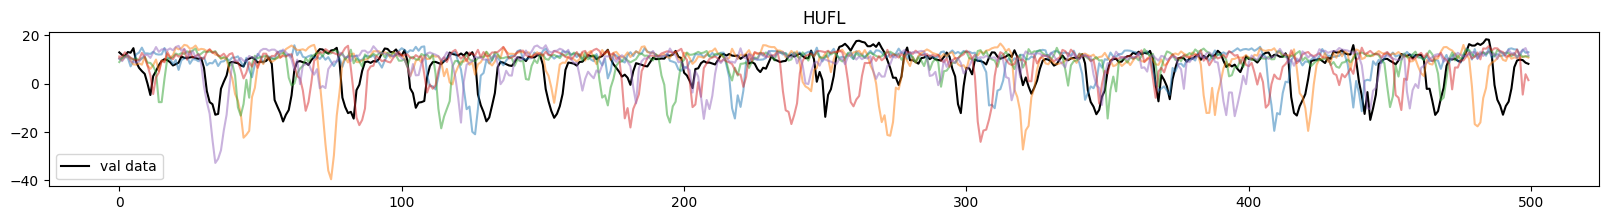

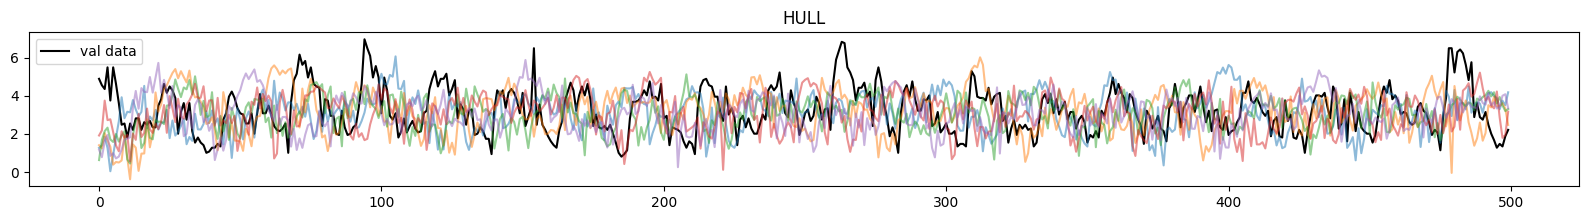

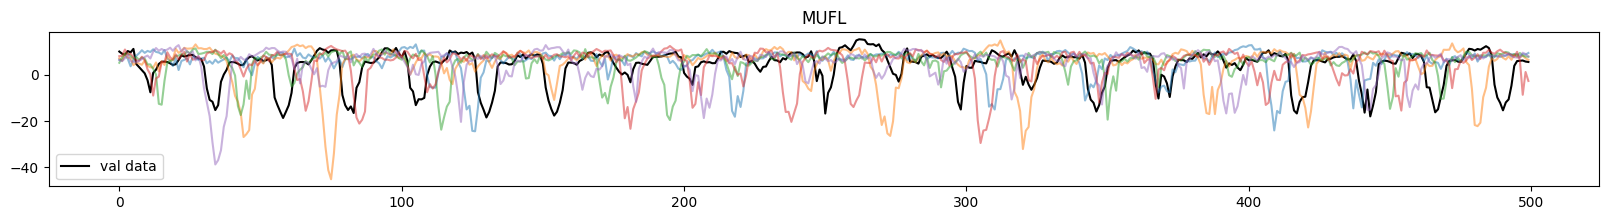

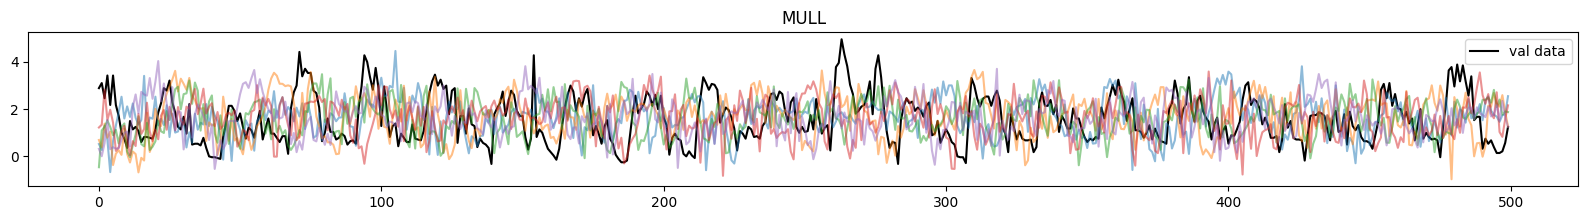

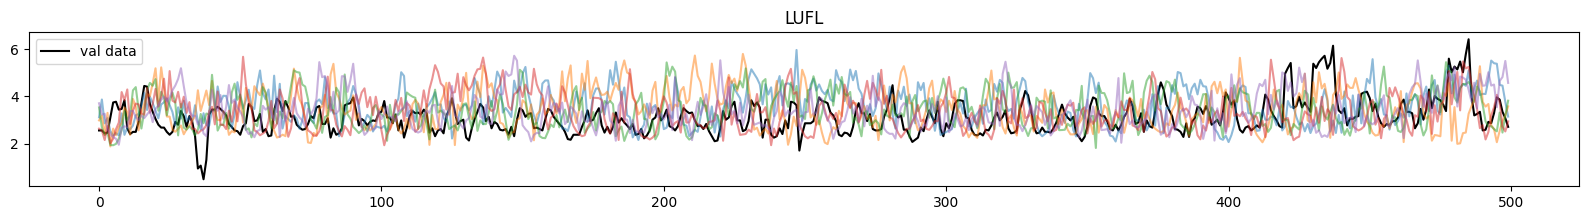

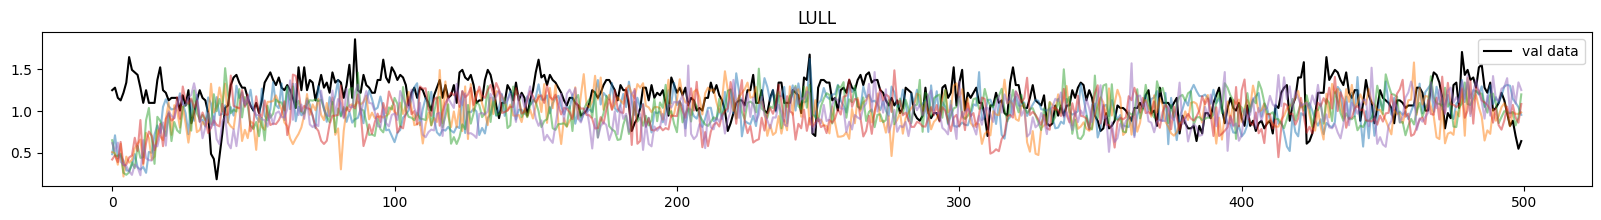

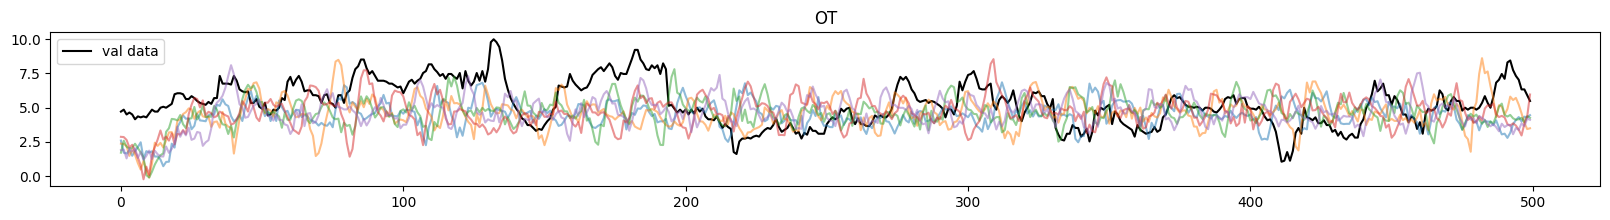

In [14]:
fakes = []
for _ in range(5):
    fake = gan.sample(len(val_data), temp=1.)
    fake = scaler.inverse_transform(fake)
    fake_data = pd.DataFrame(
        fake,
        index=val_data.index,
        columns=val_data.columns
    )
    fakes.append(fake_data)
for col in fake_data.columns:
    plt.figure(figsize=(20, 2))
    plt.plot(val_data[col].values[:500], label='val data', c='black')
    for fake_data in fakes:
        plt.plot(fake_data[col].values[:500], alpha=0.5)
    plt.legend()
    plt.title(col)
    plt.show()

We can see that the fake time series are similar to real ones. There are also some metrics such as ACF error that can give us numerical estimation of closeness to real time series. For more information, see, for example, Wiese, Magnus, et al. "Quant GANs: deep generation of financial time series." Quantitative Finance 20.9 (2020): 1419-1440.

Conclusions so far:
* We split the dataset into train, validation, test sets
* We trained GAN on the validation set, as we are looking for shifts close to the validation period
* We created fake time series and visually checked that they are similar to the real ones

## Worst case risk on fake data

Now we are ready to compare risk estimation on validation and fake sets. We download the dataset and prepare it for the regression task — predict OT attribute.

In [15]:
data = get_ett_dataset()
data["dom"] = data.index.day
data["dow"] = data.index.weekday
data["hour"] = data.index.hour
data["mnth"] = data.index.month
data['OT-1'] = data.OT.shift(1)
data = data.iloc[1:]
data.head()

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT,dom,dow,hour,mnth,OT-1
date,,,,,,,,,,,,
2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001,1,4,1,7,30.531000
2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001,1,4,2,7,27.787001
2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001,1,4,3,7,27.787001
2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000,1,4,4,7,25.044001
2016-07-01 05:00:00,5.626,2.143,1.528,0.533,4.051,1.371,21.174000,1,4,5,7,21.948000


Let us create the fake time series using GAN and then prepare the dataset in a similar way.

In [16]:
torch.manual_seed(0)
seq_len = len(val_data) * 10
fake = gan.sample(seq_len, temp=1)
fake = scaler.inverse_transform(fake)
fake_data = pd.DataFrame(
    fake,
    index=pd.date_range(start=val_data.index[0], periods=seq_len, freq='1H'),
    columns=val_data.columns
)
fake_data["dom"] = fake_data.index.day
fake_data["dow"] = fake_data.index.weekday
fake_data["hour"] = fake_data.index.hour
fake_data["mnth"] = fake_data.index.month
fake_data['OT-1'] = fake_data.OT.shift(1)
fake_data = fake_data.iloc[1:]
fake_data.head()

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT,dom,dow,hour,mnth,OT-1
2017-11-21 03:00:00,10.638646,1.772453,7.350443,0.843188,2.819726,0.567596,2.444234,21,1,3,11,2.665436
2017-11-21 04:00:00,10.861375,1.423060,6.266428,0.083447,4.096049,0.835500,0.888401,21,1,4,11,2.444234
2017-11-21 05:00:00,10.040536,1.560508,6.754908,1.138465,3.265348,0.502406,0.998027,21,1,5,11,0.888401
2017-11-21 06:00:00,9.113389,0.686894,5.173648,0.276115,2.547244,0.365143,1.500005,21,1,6,11,0.998027
2017-11-21 07:00:00,10.054921,0.976828,6.250493,0.870118,2.590225,0.245881,1.917559,21,1,7,11,1.500005


Next, we prepare train, validation, test and fake sets.

In [17]:
target_col = 'OT'
feat_cols = list(set(data.columns).difference([target_col]))

X = data[feat_cols]
y = data[target_col]

X_train = X.iloc[:val_thresh]
y_train = y.iloc[:val_thresh]

X_val = X.iloc[val_thresh:test_thresh]
y_val = y.iloc[val_thresh:test_thresh]

X_test = X.iloc[test_thresh:]
y_test = y.iloc[test_thresh:]

X_fake = fake_data[feat_cols]
y_fake = fake_data[target_col]

Train a linear regression model and calculate the error.

In [18]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

lr.fit(X_train, y_train)

preds_val = lr.predict(X_val)
preds_test = lr.predict(X_test)
preds_fake = lr.predict(X_fake)

err_val = (y_val - preds_val) ** 2
err_test = (y_test - preds_test) ** 2
err_fake = (y_fake - preds_fake) ** 2

print(f'RMSE on validation: {np.sqrt(err_val.mean()):.4f}')
print(f'RMSE on fake: {np.sqrt(err_fake.mean()):.4f}')
print(f'RMSE on test: {np.sqrt(err_test.mean()):.4f}')

RMSE on validation: 0.6163
RMSE on fake: 0.6052
RMSE on test: 0.6700


As we see, the quality on the validation set is close to the fake set. It means that the model cannot detect much discrepancy between them.

We define mutable and immutable variables.

In [19]:
immutable = ['hour', 'mnth', 'dow', 'dom']
mutable = ['MUFL', 'HUFL', 'HULL', 'OT-1', 'MULL', 'LULL', 'LUFL']

We calculate worst case risk on validation data.

100%|██████████| 5/5 [00:02<00:00,  2.38it/s]


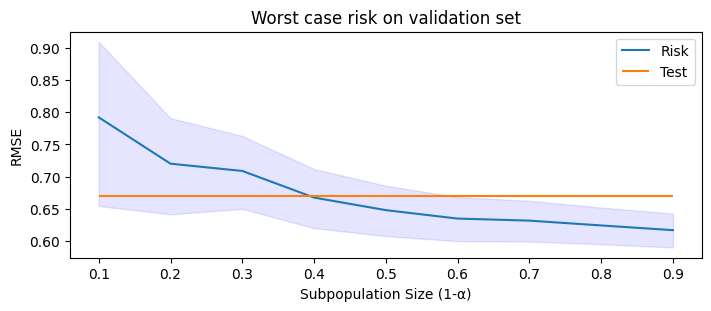

In [20]:
mn_log, lb_log, ub_log = calculate_worst_case_risk(err_val, X_val, immutable, mutable)
plot_risk(mn_log, lb_log, ub_log, err_test, 'Worst case risk on validation set')

And then: Worst case risk on fake data vs loss on test set.

100%|██████████| 5/5 [00:08<00:00,  1.68s/it]


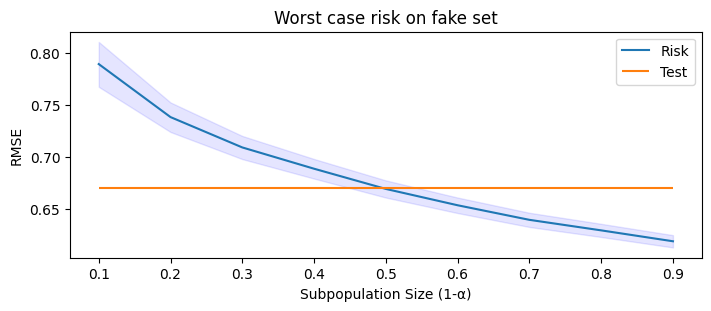

In [21]:
mn_log, lb_log, ub_log = calculate_worst_case_risk(err_fake, X_fake, immutable, mutable)
plot_risk(mn_log, lb_log, ub_log, err_test, 'Worst case risk on fake set')

As we can see, we can get a narrower uncertainty interval for fake data.

This means that we can more precisely assess the robustness of the model using fake data.

## Discussion

Generative models produce realistic data that can help estimate the model robustness to dataset shifts, however it brings some disadvantages.

1. It is hard to tune parameters and train deep generative models such GAN
2. It is hard to estimate how close the fake time series to real ones: no scientific standard so far
3. We assume that generative model can produce original data distribution

## Conclusion

In our two parts of tutorial on model validation using deep generation of stress data:

Part 1.

1. We considered the concept of supervised learning and the problem of overfitting
2. We considered the dataset shift problem, the definition and examples in real life
3. We downloaded data that contains the time series with energy consumption
4. We split the data into train, validation and test periods and observed shifts
5. We trained the regression model to forecast the oil temperature
6. We investigated the quality reduction in the test set
7. We evaluated the model robustness to dataset shifts using the Worst Case Risk methodology

Part 2.

8. We considered the concept of generative learning
9. We created the GAN model based on TCN to generate time series
10. We trained the GAN using validation data and generated fake time series
11. We visually evaluated the quality of fake time series
12. We evaluated the model robustness using fake data and got a more accurate estimate
